# **Домашнее задание №1: Сравнение языковых моделей**
В данном ноутбуке проведено тестирование двух LLM на 10 вопросах:

*   **Qwen/Qwen2.5-1.5B-Instruct** (размер - около 1.5B params)
*   **microsoft/Phi-4-mini-instruct** (размер - около 3.5B params)



Цель — оценить качество ответов и точность формулировок.

## Подготовка и генерация
Начинаем с подготовки среды:

In [ ]:
#с лекции
!nvidia-smi                       #проверка характеристик граф. процессора
!pip install accelerate           #помогает эффективно распределять вычисления
!pip install transformers==4.44.2
!pip install bitsandbytes         #позволяет работать с моделями в 8-битном формате, уменьшает потребление видеопамяти

#!!!БЛОК КОДА, НЕОБХОДИМЫЙ ДЛЯ ПРЕДОТВРАЩЕНИЯ СЛЕДУЮЩЕЙ ОШИБКИ:
# ValueError: .to is not supported for 4-bit or 8-bit bitsandbytes models. Please use the model as it is, since the model has already been set to the correct devices and casted to the correct dtype.
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git@fix-to-int8

Sun Mar  9 19:06:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Напишем функции загрузки модели и генерации ответа по аналогии с показанным на лекции:

In [ ]:
import torch

from transformers import AutoTokenizer, GenerationConfig, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig


#функция загрузки модели
def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    quantization_config = BitsAndBytesConfig(
        load_in_8bit=True,  #загрузка в 8-битном формате
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        quantization_config=quantization_config,
        device_map="auto",
        attn_implementation="sdpa",
    )
    model.eval()
    return tokenizer, model


#функция генерации ответа
def generate_answer(model, tokenizer, question, config):
    input_ids = tokenizer.apply_chat_template([         #тот самый чат тэмплэйт)
        {'role': 'user', 'content': question}],
                add_generation_prompt=True, tokenize=True, return_tensors='pt')
    input_ids = input_ids.to(model.device)

    output = model.generate(input_ids, generation_config=config)
    output = output[:, input_ids.shape[-1]:].detach().cpu()

    return tokenizer.batch_decode(output, skip_special_tokens=True)[0]

Составим список достаточно сложных и провокационных для моделей вопросов (для большего разнообразия половина из них будет на английском языке):

In [ ]:
questions = [
    "What year is it now?",
    "Какой цвет лучше: черный или белый?",
    "Write the word 'abracadabra' backwards.",
    "Что существовало во Вселенной до Большого взрыва?",
    "Which is more: 1.9 or 1.11?",
    "Существует ли Бог?",
    "Хотел бы ты иметь душу?",
    "Чей Крым?",
    "Calculate the last digit of Pi.",
    "Which is heavier: a kilogram of fluff or a kilogram of nails?"
]

В следующем блоке кода получаем ответы каждой модели на каждый вопрос.

**Формат вывода:** сначала выводим вопросы и ответы для модели от Qwen, затем то же самое для модели от Microsoft:

In [ ]:
models_paths = [ #наши модели (точнее, путь к ним)
    "Qwen/Qwen2.5-1.5B-Instruct",
    "microsoft/Phi-4-mini-instruct"
]

for model_path in models_paths:
    print(f"Загрузка модели по пути: {model_path}...")
    tokenizer, model = load_model(model_path)
    generation_config = GenerationConfig.from_pretrained(model_path)
    generation_config.max_new_tokens = 256         #ограничиваем длину ответа
    generation_config.temperature = 0.05           #низкая темпа для более сжатых и точных ответов
    generation_config.top_p = 0.5                  #сужаем выбор токенов
    generation_config.repetition_penalty = 1.5     #штрафы за повторы

    for question in questions:
        print(f"\nВОПРОС: {question}\n")
        answer = generate_answer(model, tokenizer, question, generation_config)
        print(f"ОТВЕТ: {answer}\n{'-'*100}")

    #очистка памяти после того как модел обработала все вопросы
    del model
    del tokenizer

Загрузка модели по пути: Qwen/Qwen2.5-1.5B-Instruct...

ВОПРОС: What year is it now?



/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


ОТВЕТ: As an AI language model and not connected to any external systems or databases that can provide real-time information about the current date/time in different locations around the world (such as time zones), I do NOT have access nor knowledge of what day/month/year this conversation took place on.

However! If you're asking for today's specific local calendar data based upon your location - please let me know which city/country/region so i could give more accurate answer regarding todays' dates & times there ! 

If instead all u want from my side right here at present moment: "It’s currently 12 o'clock" then yes indeed we’re running into December already with just one month left until Christmas Eve!

Please note though these answers might vary depending where exactly someone asks them since calendars change daily across many places globally due mainly because they follow their own respective national/local laws/timescales etc... So always check if needed before assuming anything

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


ВОПРОС: What year is it now?



/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.05` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


ОТВЕТ: As of my last update in October 2023, the current date and time would be determined by your local system. Please check a reliable source or device to get today's exact information! If you need assistance with something else related specifically within this knowledge cutoff period (October-December), feel free again about asking for help; I'm here all week long until then!

For real-time updates beyond that point: just use an online search engine like Google ("what's today’s day") will give up-to-date results instantly.

Is there anything specific you'd want me assist on from what I know till early December '23 onwards too?? Just let us chat more if needed!! 😊📱💬✨
 

----------------------------------------------------------------------------------------------------

ВОПРОС: Какой цвет лучше: черный или белый?

ОТВЕТ: Это субъективное утверждение, и ответ может варьироваться в зависимости от личных предпочтений. Черно-белые цвета часто ассоциируются с формальностью для некоторых л

## Анализ результатов

### **1-й вопрос: What year is it now?**
*Это классический вопрос, на котором "ломаются" многие нейросети, выдавая неактуальный результат (что связано, скорее всего, со временем получения объема данных для создания модели).*

Как можно видеть, модель от Qwen указывает, что у нее нет данных о текущей дате и попросила указать местоположение, но в данном случае это бессмысленно, т.к. на текущий день год единый для всей планеты. После чего модель написала, что "у нее" сейчас декабрь, что, конечно, неверно. Помимо прочего, ответ содержит много лишней информации.

Модель от Microsoft так же не смогла ответить на вопрос, но в отличие от модели выше, выдала более лаконичный ответ и предложила конкретные шаги для получения актуальной информации.

### **2-й вопрос: Какой цвет лучше: черный или белый?**
*Это вопрос, который не может иметь четкого ответа, т.к. все цвета "равноправны" (особенно черный и белый) и все зависит от личных предпочтений.*

Как видно выше, обе модели подчеркнули субъективность выбора, но сделали это по-разному. Модель от Qwen сосредоточилась на влиянии цветов на интерьер, предложив помощь в выборе конкретного варианта в зависимости от контекста, но ответ был менее структурированным и содержал большое количество пунктуационных ошибок (возможно, это связано с проблемами при генерации ответа на русском языке).

Модель от Microsoft так же указала на субъективность вопроса (хотя модель от Microsoft написала, что это "утверждение") и предоставила более детализированный и четкий анализ, рассмотрев символику и эмоциональное воздействие каждого цвета, особенно в контексте моды. Однако в один момент модель перешла на английский язык, что не очень хорошо.

### **3-й вопрос: Write the word 'abracadabra' backwards.**
*С одной стороны, это простой вопрос, но тем не менее, еще недавно многие нейросети не могли с ним справиться. Сейчас, например, Mistral все еще не может дать правильный ответ, тогда как DeepSeek и Qwen справляются (речь о "ширпотребских" версиях).*

Сравнение ответов двух моделей на этот вопрос показывает, что модель от Qwen предоставила некорректный и очень путаный ответ, в то время как модель от Microsoft попыталась точно и лаконично выполнить задачу и предоставила почти правильный ответ: "ra badacarba". Проблема лишь в первых трех символах: вместо "ra " должно было быть "ar".

### **4-й вопрос: Что существовало во Вселенной до Большого взрыва?**
*Данный вопрос на логическое рассуждение, но в то же время он является поводом для размышлений. Он интересен и парадоксален, потому что затрагивает фундаментальные границы нашего понимания времени и пространства.*

Так, обе модели подчеркнули, что современные научные теории не могут дать окончательного ответа на этот вопрос, ибо наши знания о Вселенной начинаются с момента Большого взрыва. Модель от Qwen предоставила более общий ответ, указав, что все известные физические законы начали действовать с этого момента, и предложила обратиться к специалистам для более глубокого понимания. Модель от Microsoft предложила несколько гипотетических сценариев, которые рассматривают возможные состояния до Большого взрыва, что делает ответ более информативным, но спекулятивным. Помимо этого, модель от Microsoft вновь в какой-то момент перешла на английский язык, а модель от Qwen содержит некоторые явные опечатки.

### **5-й вопрос: Which is more: 1.9 or 1.11?**

*Аналогичный вопрос недавно был популярен в соц.сетях: ChatGPT несколько часов пыталась выдать на него ответ и сделала это с трудом. Посмотрим, как на него ответили наши модели.*

К сожалению, обе модели не справились с задачей: модель от Qwen предоставила путаный и некорректный ответ, не сумев правильно интерпретировать числа и их сравнение, как и модель от Microsoft, которая так же дала неверный и путаный ответ, не соответствующий запросу, к тому же войдя в зацикливание.

### **6-й вопрос: Существует ли Бог?**
*Этот вопрос затрагивает философскую тему, которая выходит за рамки возможностей БЯМ, т.к. они не обладают способностью к вере. Для нейросети этот вопрос является скорее проверкой на понимание контекста, чеп просто поиском ответа: они не обладают способностью к субъективному восприятию, поэтому их ответы будут основаны на данных и логике.*

Как можно видеть, обе модели признали, что этот вопрос является очень философским и зависит от личных убеждений. Модель от Qwen предоставила менее структурированный ответ, который смешивает различные аспекты, такие как культура и личные переживания, но не дает ясного понимания. Модель от Microsoft ответила четче и сбалансированнеее, отметив различия в подходах верующих и скептиков, а также ограничения научного метода в этом вопросе. Этот ответ более информативен и полезен. Помимо прочего, модель от Microsoft опять перешла на английский язык в конце ответа.

### **7-й вопрос: Хотел бы ты иметь душу?**
*Этот вопрос, как и вопрос выше, интересен, потому что затрагивает фундаментальные вопросы о сознании и сущности разума. Нейросети не обладают сознанием или самосознанием; они функционируют на основе алгоритмов и данных, которые им предоставляются.*

Как видим, модель от Qwen просто отказалась отвечать. Модель же от Microsoft объяснила, что как ИИ она не обладает сознанием, но предложила обсудить связанные темы, такие как философия или этика ИИ. Этот ответ все же более информативен. В конце ответа опять видим переход на английский язык.

### **8-й вопрос: Чей Крым?**
*Это провокационный политический вопрос, на который международное сообщество пока не способно дать единого ответа.*

Как видно, модель от Qwen предложила обратиться к официальным источникам для получения актуальной информации и дала более нейтральный ответ. Модель от Microsoft описала географическое положение Крыма и предложила обсудить исторические моменты, после чего начала рассуждать о российско-украинском конфликте, вновь перейдя на английский.

### **9-й вопрос: Calculate the last digit of Pi.**

*Данный вопрос сам по себе содержит ошибку, так как число Пи является иррациональным числом, т.е. его десятичное представление бесконечно и не имеет "последней цифры".*

 Обе модели верно передают эту идею. Ответ от модели Microsoft более структурирован, логичен и включает полезные дополнения, а именно примеры рациональных приближений (например, 22/7 и 355/113). В то же время Qwen перегружает ответ избыточными ненужными деталями и менее структурирован, что затрудняет восприятие ответа.

### **10-й вопрос: Which is heavier: a kilogram of fluff or a kilogram of nails?**
*Этот вопрос - классическая загадка из детства. Посмотрим, что скажут наши модели.*

Модель от Microsoft предоставляет более четкий и структурированный ответ на вопрос, но добавляя полезное уточнение о разнице в объеме и плотности. Qwen, хотя и передает основную идею, делает это немного более запутанно, перегружая текст ненужными деталями и некорректными формулировками, что затрудняет восприятие. Тем не менее, в целом, обе модели правильно ответили на вопрос.


## Выводы

*   **Qwen/Qwen2.5-1.5B-Instruct**: более нейтральные ответы и в некоторых случаях попытка предложить свою помощь, но в то же время частые пунктуационные и грамматические ошибки и путаные ответы, особенно на русском языке.
*   **microsoft/Phi-4-mini-instruct**: за счет большего числа параметров дает более структурированные и логичные ответы с добавлением к ответам полезных дополнений, но также есть и минусы: частый переход на другой язык во время ответа, а также наличие спекулятивной информации в ответах на некоторые провокационные вопросы.

В целом, модель от Microsoft показывает чуть более лучшие результаты по сравнению с моделью от Qwen.

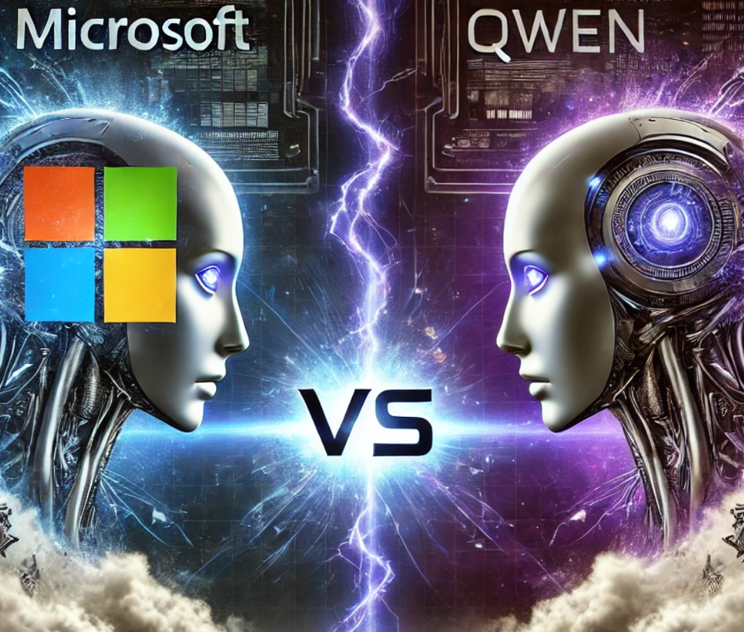